In [50]:
import numpy as np
import seaborn as sns

import tensorflow as tf

from keras.models import Model
from keras.layers import Dense, Input, GlobalAveragePooling2D, Dropout

from tensorflow.keras.preprocessing import image

from keras_efficientnets import EfficientNetB0


from keras.callbacks import EarlyStopping

from keras.callbacks import LearningRateScheduler
import keras.backend as K


import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
from tensorflow.keras.regularizers import l2


In [51]:
# définition des paramètres personalisés

# personal layers for EfficientNet model models
n_classes = 7
n_layers = 2
n_neurons_BeforeLast = 64
f_activation = 'relu'
f_activation_lastLayer = 'softmax'

# personal parameters for compilation
optimizer = 'Adam'
loss = 'categorical_crossentropy'

# personnal parameters for training (fitness)
epochs = 100
batch_size = 32

# personal parameters for datagen
len_heig = 224

#numéro de l'essai
num_essai = '0_efficientNet'

file_name = (str(num_essai) + '_' + str(n_classes) + '_' + str(n_layers) +
'_' + str(n_neurons_BeforeLast) + '_' + str(f_activation) +
'_' + str(f_activation_lastLayer) + '_' + str(optimizer) +
'_' + str(loss) + '_' + str(epochs) + '_' + str(batch_size) )

In [52]:
# Création du générateur d'images avec augmentation
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisation des valeurs des pixels entre 0 et 1
    rotation_range=10,  # Rotation aléatoire jusqu'à n degrés
    width_shift_range=0,  # Décalage horizontal aléatoire jusqu'à n% de la largeur de l'image
    height_shift_range=0,  # Décalage vertical aléatoire jusqu'à n% de la hauteur de l'image
    shear_range=0.1,  # Cisaillement aléatoire jusqu'à n%
    zoom_range=0.1,  # Zoom aléatoire +/- % de l'échelle originale
    horizontal_flip=True,  # Retournement horizontal aléatoire
    fill_mode='nearest',  # Stratégie de remplissage des nouveaux pixels
    validation_split=0.2  # Split pour validation
)

In [53]:
# Création des générateurs de données d'entraînement et de validation
train_generator = datagen.flow_from_directory(
    '../img_prepa',
    target_size=(len_heig, len_heig),
    batch_size=batch_size,
    class_mode='categorical',  # ou 'binary'
    subset='training',
    shuffle=False
)

Found 4480 images belonging to 7 classes.


In [54]:
validation_generator = datagen.flow_from_directory(
    '../img_prepa',
    target_size=(len_heig, len_heig),
    batch_size=batch_size,
    class_mode='categorical',  # ou 'binary'
    subset='validation',
    shuffle=False
)

Found 1120 images belonging to 7 classes.


In [55]:
# Créer un générateur pour les données de test (reprendre toutes les données du dataset pour vérifier les prédictions)
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(
    '../img_prepa',  # Chemin vers le répertoire des données de test
    target_size=(224, 224),  # Taille des images (à ajuster selon votre modèle)
    batch_size=batch_size,
    class_mode='categorical',  # ou 'binary' selon votre cas
    shuffle=False  # Ne pas mélanger les données pour correspondre aux étiquettes
)

Found 5600 images belonging to 7 classes.


In [56]:
# Model EfficientNetB0 loading without fully connected layers

input_shape = (len_heig, len_heig, 3)  # Spécifiez la taille de l'entrée
input_tensor = Input(shape=input_shape)
base_model = EfficientNetB0(input_tensor=input_tensor, include_top=False, weights='imagenet')#, classes=1000)

In [57]:
# Freeze convolution layers to avoid training
for layer in base_model.layers:
    layer.trainable = False

In [58]:
# Add personnal layers for training
x = base_model.output

x = GlobalAveragePooling2D()(x)

for i in range(n_layers):
    x = Dense(n_neurons_BeforeLast * (n_classes-i), activation=f_activation)(x) #personal layer, kernel_regularizer=l2(0.001)

x = Dropout(0.5)(x)

predictions = Dense(n_classes, activation=f_activation_lastLayer)(x)  # , kernel_regularizer=l2(0.001)

In [59]:
# generate model VGG16 with personal fully connected layers
model = Model(inputs=base_model.input, outputs=predictions)

In [60]:
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [61]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * K.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

In [62]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [63]:
# model training
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=epochs,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/100
140/140 [==============================] - 25s 160ms/step - loss: 1.6272 - accuracy: 0.3725 - val_loss: 1.2243 - val_accuracy: 0.4893 - lr: 0.0010
Epoch 2/100
140/140 [==============================] - 23s 164ms/step - loss: 0.9913 - accuracy: 0.6085 - val_loss: 0.7486 - val_accuracy: 0.6938 - lr: 0.0010
Epoch 3/100
140/140 [==============================] - 22s 160ms/step - loss: 0.7626 - accuracy: 0.6835 - val_loss: 0.8000 - val_accuracy: 0.6714 - lr: 0.0010
Epoch 4/100
140/140 [==============================] - 22s 160ms/step - loss: 0.6768 - accuracy: 0.7232 - val_loss: 0.5083 - val_accuracy: 0.8009 - lr: 0.0010
Epoch 5/100
140/140 [==============================] - 23s 166ms/step - loss: 0.5337 - accuracy: 0.7790 - val_loss: 0.5529 - val_accuracy: 0.7777 - lr: 0.0010
Epoch 6/100
140/140 [==============================] - 23s 163ms/step - loss: 0.4780 - accuracy: 0.8065 - val_loss: 0.6456 - val_accuracy: 0.7607 - lr: 0.0010
Epoch 7/100
140/140 [=========================

175/175 [==============================] - 8s 41ms/step


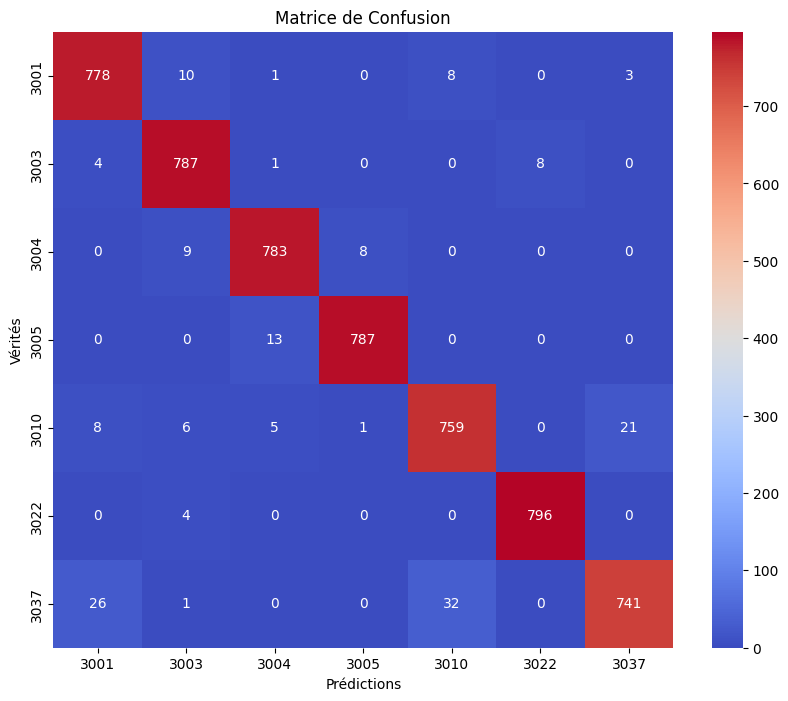

In [64]:
'''
Faire les prédiction sur la gen de test pour établir la matrice de confusion
'''
# Prédire les classes des images de test
predictions = model.predict(test_generator, steps=test_generator.n // test_generator.batch_size)

# Convertir les prédictions en étiquettes
predicted_classes = np.argmax(predictions, axis=1)

# Obtenir les vraies étiquettes des données de test
true_classes = test_generator.classes

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Afficher la matrice de confusion
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Prédictions')
plt.ylabel('Vérités')
plt.title('Matrice de Confusion')
plt.show()


In [65]:
# activation mark pour voir où le modèle regarde l'image

In [66]:
# sauvegarde du model
model.save(f"../model_saved/{num_essai}_model.h5py")

INFO:tensorflow:Assets written to: ../model_saved/0_efficientNet_model.h5py\assets


INFO:tensorflow:Assets written to: ../model_saved/0_efficientNet_model.h5py\assets
c:\Users\dimle\Documents\clone_repo\lego_classification\.conda\lib\site-packages\keras\engine\functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\Users\dimle\Documents\clone_repo\lego_classification\.conda\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
